In [1]:
import torch
import torch.nn as nn

import seaborn as sns
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
flight_data = sns.load_dataset("flights")
flight_data.head()

,year,month,passengers
0,1949,Jan,112
1,1949,Feb,118
2,1949,Mar,132
3,1949,Apr,129
4,1949,May,121


In [3]:
print(flight_data.tail())
print("shape : ",flight_data.shape)

     year month  passengers
139  1960   Aug         606
140  1960   Sep         508
141  1960   Oct         461
142  1960   Nov         390
143  1960   Dec         432
shape :  (144, 3)


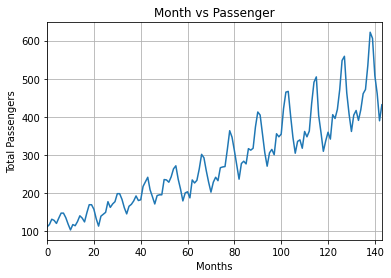

In [4]:
plt.title('Month vs Passenger')
plt.ylabel('Total Passengers')
plt.xlabel('Months')
plt.grid(True)
plt.autoscale(axis='x',tight=True)
plt.plot(flight_data['passengers'])

In [5]:
all_data = flight_data['passengers'].values.astype(float)


In [6]:
all_data = flight_data['passengers'].values.astype(float)
print(all_data)

[112. 118. 132. 129. 121. 135. 148. 148. 136. 119. 104. 118. 115. 126.
 141. 135. 125. 149. 170. 170. 158. 133. 114. 140. 145. 150. 178. 163.
 172. 178. 199. 199. 184. 162. 146. 166. 171. 180. 193. 181. 183. 218.
 230. 242. 209. 191. 172. 194. 196. 196. 236. 235. 229. 243. 264. 272.
 237. 211. 180. 201. 204. 188. 235. 227. 234. 264. 302. 293. 259. 229.
 203. 229. 242. 233. 267. 269. 270. 315. 364. 347. 312. 274. 237. 278.
 284. 277. 317. 313. 318. 374. 413. 405. 355. 306. 271. 306. 315. 301.
 356. 348. 355. 422. 465. 467. 404. 347. 305. 336. 340. 318. 362. 348.
 363. 435. 491. 505. 404. 359. 310. 337. 360. 342. 406. 396. 420. 472.
 548. 559. 463. 407. 362. 405. 417. 391. 419. 461. 472. 535. 622. 606.
 508. 461. 390. 432.]


Train-Test Split. Last 12 Month will be tested

In [7]:
test_data_size = 12

train_data = all_data[:-test_data_size]
test_data = all_data[-test_data_size:]

print(len(train_data))
print(len(test_data))

132
12


in Time Series Normalization is required. It will be normalized in range (-1,1) 

In [8]:
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler(feature_range=(-1, 1))
train_data_normalized = scaler.fit_transform(train_data .reshape(-1, 1))

#132 row, 1 column is produced.

In [9]:
print(train_data_normalized[:5])


[[-0.96483516]
 [-0.93846154]
 [-0.87692308]
 [-0.89010989]
 [-0.92527473]]


In [10]:
train_data_normalized.shape

(132, 1)

In [11]:
# Flattened and Tensored it again
train_data_normalized = torch.FloatTensor(train_data_normalized).view(-1)
train_data_normalized.shape

torch.Size([132])

In [12]:
window_size = 12

def create_inout_sequences(input_data, ws):
    inout_seq = []
    L = len(input_data)
    for i in range(L-ws):
        train_seq = input_data[i:i+ws]
        train_label = input_data[i+ws:i+ws+1]
        inout_seq.append((train_seq ,train_label))
    return inout_seq

train_inout_seq = create_inout_sequences(train_data_normalized, window_size)

print(train_inout_seq[-1])
print(len(train_inout_seq))

(tensor([0.0242, 0.1253, 0.0462, 0.3275, 0.2835, 0.3890, 0.6176, 0.9516, 1.0000,
        0.5780, 0.3319, 0.1341]), tensor([0.3231]))
120


#Model

In [42]:
class LSTM(nn.Module):
    def __init__(self, input_size=1, hidden_layer_size=100, output_size=1):
        super().__init__()
        self.hidden_layer_size = hidden_layer_size

        self.lstm = nn.LSTM(input_size, hidden_layer_size, num_layers = 1, batch_first = True)
        self.linear = nn.Linear(hidden_layer_size, output_size)

        #num layers*num direction,batch,hidden_size
        #self.hidden_cell = (torch.zeros(1,1,self.hidden_layer_size),
         #                   torch.zeros(1,1,self.hidden_layer_size))

    def forward(self, input_seq):

        print("input shape: ",input_seq.view(1,len(input_seq),-1).shape)

        lstm_out, self.hidden_cell = self.lstm(input_seq.view(1,len(input_seq),-1))

        print("hidden cell : ",self.hidden_cell[0].shape," ",self.hidden_cell[1].shape)
        print("lstm out : ",lstm_out.shape)

        predictions = self.linear(lstm_out)

        print("prediction shape : ",predictions.shape)
        print("prediction shape : ",predictions[-1].shape)

        return predictions[-1]

In [43]:
model = LSTM()
loss_function = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)


LSTM(
  (lstm): LSTM(1, 100, batch_first=True)
  (linear): Linear(in_features=100, out_features=1, bias=True)
)


In [39]:
# train_input is list, every one item in the list is tuple returning seq array and labels
for seq,labels in train_inout_seq:
  print(seq)
  print(labels)
  print(seq.view(1,len(seq), -1))
  print(seq.view(1,len(seq), -1).shape)
  break

tensor([-0.9648, -0.9385, -0.8769, -0.8901, -0.9253, -0.8637, -0.8066, -0.8066,
        -0.8593, -0.9341, -1.0000, -0.9385])
tensor([-0.9516])
tensor([[[-0.9648],
         [-0.9385],
         [-0.8769],
         [-0.8901],
         [-0.9253],
         [-0.8637],
         [-0.8066],
         [-0.8066],
         [-0.8593],
         [-0.9341],
         [-1.0000],
         [-0.9385]]])
torch.Size([1, 12, 1])


In [44]:
for seq,labels in train_inout_seq:
  a = model(seq)
  break

input shape:  torch.Size([1, 12, 1])
hidden cell :  torch.Size([1, 1, 100])   torch.Size([1, 1, 100])
lstm out :  torch.Size([1, 12, 100])
prediction shape :  torch.Size([1, 12, 1])
prediction shape :  torch.Size([12, 1])


In [54]:
a = nn.Linear(12,2)

In [55]:
# 1,12,1 entered.
seq1 = seq.reshape(1,12)
result = a(seq1)
result.shape

torch.Size([1, 2])

Layer look to the last element of shape. 1,12,1 entered linear(1,13) : 1,12,3. But 1,12 entered linear(12,13) : 1,13

In [25]:
epochs = 150

train_loss = []
for i in range(epochs):
    epoch_loss = []
    for seq, labels in train_inout_seq:
        optimizer.zero_grad()
        #model.hidden_cell = (torch.zeros(1, 1, model.hidden_layer_size),
         #               torch.zeros(1, 1, model.hidden_layer_size))

        y_pred = model(seq)

        single_loss = loss_function(y_pred, labels)        
        single_loss.backward()
        optimizer.step()

        epoch_loss.append(single_loss.item())

    average_epoch_loss = sum(epoch_loss)/len(epoch_loss)
    train_loss.append(average_epoch_loss)
    


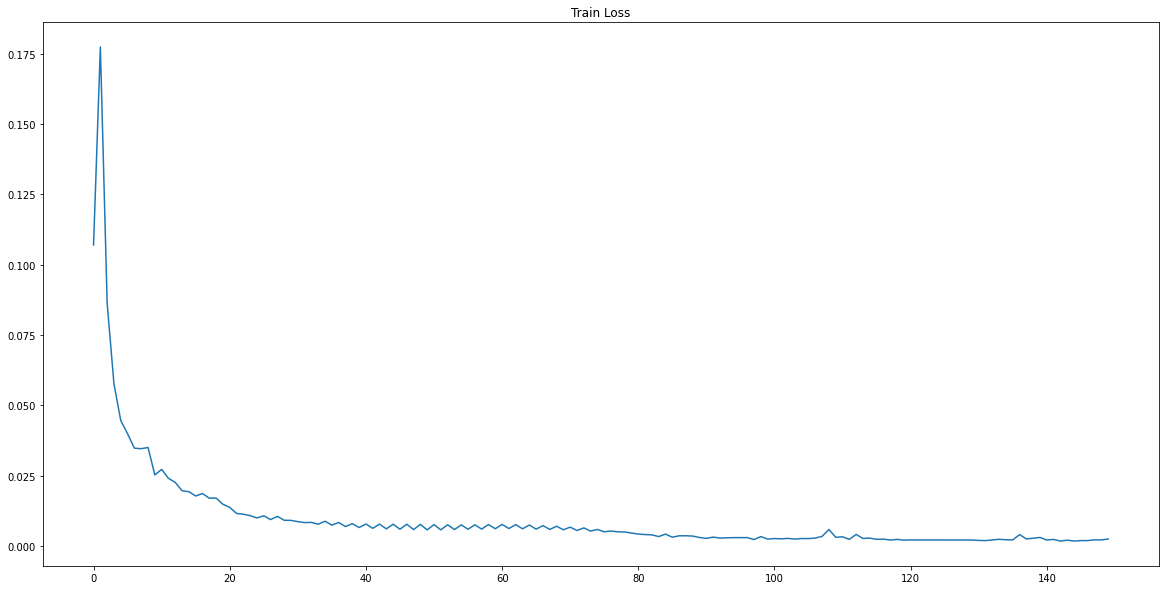

Last Loss 0.002511288628510518


In [17]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 10

plt.plot(train_loss)
plt.title("Train Loss")
plt.show()

print(f"Last Loss {train_loss[-1]}")

In [18]:
fut_pred = 12

test_inputs = train_data_normalized[-window_size:].tolist()
print(test_inputs)


[0.12527473270893097, 0.04615384712815285, 0.3274725377559662, 0.2835164964199066, 0.3890109956264496, 0.6175824403762817, 0.9516483545303345, 1.0, 0.5780220031738281, 0.33186814188957214, 0.13406594097614288, 0.32307693362236023]


In [19]:
model.eval()
# iteratively do prediction for 13.month then append it. do prediction for 1-13 month do prediction. do prediction for 2-14 month so on so forth.

for i in range(fut_pred):
    seq = torch.FloatTensor(test_inputs[-window_size:])
    with torch.no_grad():
        #model.hidden = (torch.zeros(1, 1, model.hidden_layer_size),
                        #torch.zeros(1, 1, model.hidden_layer_size))
        test_inputs.append(model(seq).item())


test_inputs[fut_pred:]


[0.40259069204330444,
 0.3045390844345093,
 0.6008407473564148,
 0.8895153999328613,
 1.2684916257858276,
 1.6735049486160278,
 2.0683205127716064,
 2.401402711868286,
 1.7416685819625854,
 1.7479335069656372,
 1.708396077156067,
 1.735251545906067]

In [20]:
actual_predictions = scaler.inverse_transform(np.array(test_inputs[window_size:] ).reshape(-1, 1))
print(actual_predictions)

[[423.08938244]
 [400.78264171]
 [468.19127002]
 [533.86475348]
 [620.08184487]
 [712.22237581]
 [802.04291666]
 [877.81911695]
 [727.7296024 ]
 [729.15487283]
 [720.16010755]
 [726.26972669]]


In [21]:
test_data_expanded = test_data.reshape(12,1)
test_data_expanded

array([[417.],
       [391.],
       [419.],
       [461.],
       [472.],
       [535.],
       [622.],
       [606.],
       [508.],
       [461.],
       [390.],
       [432.]])

In [22]:
loss_function(torch.tensor(actual_predictions),torch.tensor(test_data_expanded))

tensor(40273.9520, dtype=torch.float64)

In [ ]:
#https://stackabuse.com/time-series-prediction-using-lstm-with-pytorch-in-python/